In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [16]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 500
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [3]:
def load_all(fname):
    return pickle.load(open(fname,"rb"))

X_train_all = load_all("X_train_all_90.pkl")
X_val_all = load_all("X_val_all_90.pkl")

In [4]:
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

y_train = load_y(path+"y_train.p")
y_val = load_y(path+"y_val.p")

In [5]:
print (X_train_all[0].shape)
print (X_train_all.shape)
print (X_train_all[0])
print (max(X_train_all[0]))
print (X_val_all[0].shape)
print (X_val_all.shape)
print (X_val_all[0])
print (max(X_val_all[0]))

(6000,)
(75000, 6000)
[  9.30213571 -30.65635962   2.24770751 ...   0.99585652   0.98546931
  -0.19068967]
17.55310737780931
(6000,)
(15000, 6000)
[ 1.99361009e+00 -2.76372462e+01  5.95588185e+00 ...  2.79753789e-01
 -1.65552558e-01  2.11403750e-02]
15.609482222685395


In [6]:
from sklearn import svm

In [7]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1],
     'gamma': [0.001, 0.01, 0.1, 1]
 }

In [8]:
gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='rbf'), 
                      parameters, cv=3, iid=True, n_jobs=10, verbose=2)

In [9]:
stime=time.time()
model = gs_clf.fit(X_train_all, y_train)
print ("GridSearchTime:",time.time()-stime)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 266.1min
[Parallel(n_jobs=10)]: Done  48 out of  48 | elapsed: 452.9min finished


[LibSVM]GridSearchTime: 34306.68499517441


/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [10]:
model.best_score_

0.5804533333333334

In [11]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 0.1, 'gamma': 0.001}
C: 0.1
gamma: 0.001


In [12]:
pickle.dump(model,open("SVM_All_RBF_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [17]:
X_test_all = load_all("X_test_all_90.pkl")
y_test = load_y(path+"y_test.p")

In [18]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        kernel='rbf',
                        C=model.best_params_['C'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    bestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_val = bestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    preds_test = bestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_all)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)
print (preds_test_probs)

SampleSize: 100
[LibSVM]Train Time:0.41 sec
Validation Accuracy: 50.00%
Validation Time:8.52 sec
Test Accuracy: 50.00%
Test Time:8.76 sec
(0.2857142857142808, 0.0, 0.0)
MRR: 0.2857142857142808
MRR Time:9.28 sec
SampleSize: 500
[LibSVM]Train Time:7.31 sec
Validation Accuracy: 50.00%
Validation Time:44.26 sec
Test Accuracy: 50.00%
Test Time:44.12 sec
(0.43561587301587473, 0.17133333333333334, 0.552)
MRR: 0.43561587301587473
MRR Time:44.93 sec
SampleSize: 1000
[LibSVM]Train Time:31.32 sec
Validation Accuracy: 50.00%
Validation Time:93.28 sec
Test Accuracy: 50.00%
Test Time:93.30 sec
(0.4388460317460332, 0.174, 0.56)
MRR: 0.4388460317460332
MRR Time:93.87 sec
SampleSize: 10000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:763.88 sec
Validation Accuracy: 50.36%
Validation Time:187.14 sec
Test Accuracy: 50.29%
Test Time:186.46 sec
(0.4606042809042826, 0.20733333333333334, 0.5873333333333334)
MRR: 0.4606042809042826
MRR Time:189.29 sec
SampleSize: 20000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:1526.57 sec
Validation Accuracy: 55.53%
Validation Time:186.71 sec
Test Accuracy: 54.88%
Test Time:186.69 sec
(0.45844179894180054, 0.202, 0.5946666666666667)
MRR: 0.45844179894180054
MRR Time:187.53 sec
SampleSize: 50000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:4186.85 sec
Validation Accuracy: 53.15%
Validation Time:209.05 sec
Test Accuracy: 53.77%
Test Time:210.02 sec
(0.4613460317460334, 0.21, 0.588)
MRR: 0.4613460317460334
MRR Time:211.84 sec
SampleSize: 75000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:6410.40 sec
Validation Accuracy: 52.39%
Validation Time:208.74 sec
Test Accuracy: 52.50%
Test Time:209.27 sec
(0.4582587301587313, 0.20333333333333334, 0.5873333333333334)
MRR: 0.4582587301587313
MRR Time:211.98 sec
[0.5, 0.5, 0.5, 0.5036, 0.5553, 0.5315, 0.5239]
[0.5, 0.5, 0.5, 0.5029, 0.5488, 0.5377, 0.525]
[0.2857142857142808, 0.43561587301587473, 0.4388460317460332, 0.4606042809042826, 0.45844179894180054, 0.4613460317460334, 0.4582587301587313]
[0.0, 0.17133333333333334, 0.174, 0.20733333333333334, 0.202, 0.21, 0.20333333333333334]
[0.0, 0.552, 0.56, 0.5873333333333334, 0.5946666666666667, 0.588, 0.5873333333333334]
[[0.53327283 0.46672717]
 [0.53306127 0.46693873]
 [0.53307017 0.46692983]
 ...
 [0.5330698  0.4669302 ]
 [0.5330698  0.4669302 ]
 [0.5330698  0.4669302 ]]


In [21]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_RBF_Accuracy.png")
    #plt.show()

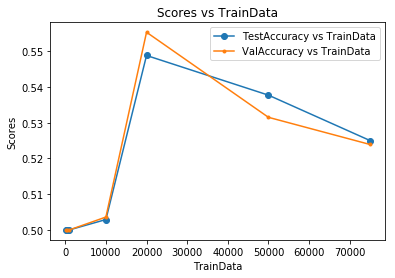

In [22]:
accuracyVisualization()

In [23]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_RBF_Mrr.png")
    plt.show()

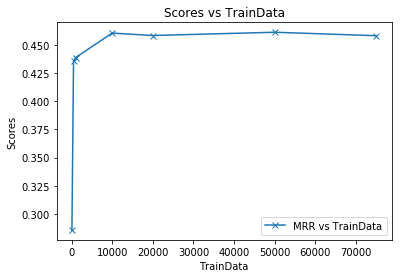

In [24]:
mrrVisualization()

In [25]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_All_RBF_Precision.png")
    plt.show()

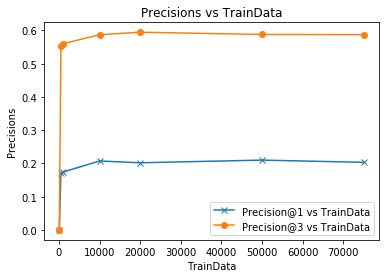

In [26]:
precisionVisualization()